In [21]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
import pickle
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
import json
import seaborn as sb
import IO
from sklearn import linear_model
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
from collections import OrderedDict

def get_int_runs(subject_id, subfolder):
    """
    :param patient_idx:
    :return: list with all run files for the given patient
    """
    os.listdir(settings['out_path'])

    if 'right' in str(subfolder):
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_right') and i.endswith('.p')]
    else:
        list_subject = [i for i in os.listdir(settings['out_path']) if i.startswith('sub_'+subject_id+'_sess_left') and i.endswith('.p')]

    return list_subject

In [10]:
settings = {}
settings['frequencyranges']=[[4, 8], [8, 12], [13, 20], [20, 35], [13, 35], [60, 80], [90, 200], [60, 200]]
settings['seglengths']=[1, 2, 2, 3, 3, 3, 10, 10, 10]
settings['num_patients']=['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
settings['BIDS_path'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\"
settings['out_path'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\derivatives\\Int_old_grid\\"
settings['out_path_process'] = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\MOVEMENT DATA\\ECoG_STN\\LM_8fbands_nonCV\\"

In [11]:
# here: read every .p file and use LM's only for individual time points and f-bands 

In [124]:
laterality=[("CON"), ("IPS")]
signal=["STN", "ECOG"]

for signal_idx, signal_ in enumerate(signal):
    for sub_idx in np.arange(0, len(settings['num_patients']), 1):
        subject_path=settings['BIDS_path'] + 'sub-' + settings['num_patients'][sub_idx]
        subfolder=IO.get_subfolders(subject_path)
        for sess_idx in range(len(subfolder)):
            X=[]
            Y_con=[]
            Y_ips=[]
            list_subject=get_int_runs(settings['num_patients'][sub_idx], subfolder[sess_idx])
            list_subject=sorted(list_subject)
            print('RUNNIN SUBJECT_'+ settings['num_patients'][sub_idx]+ '_SESS_'+ str(subfolder[sess_idx]) + '_SIGNAL_' + signal_)
            if signal_ == "ECOG":
                if sub_idx==4 and sess_idx==0: #for sake of comparison with spoc
                    list_subject.pop(0)
                if sub_idx==4 and sess_idx==1:
                    list_subject.pop(2)
                    
            for run_idx in range(len(list_subject)):
                with open(settings['out_path']+ '/'+ list_subject[run_idx], 'rb') as handle:
                    run_ = pickle.load(handle)
                #concatenate features
                if signal_=="ECOG":
                    ind_cortex=run_['used_channels']['cortex']
                    rf=run_['rf_data_median']
                    x=rf[:,ind_cortex,:]
                    x=np.clip(x, -2,2) # this should have been implemented in the pipeline
                    y=run_['label_baseline_corrected']
                    con_true=run_['label_con_true']
                    y_con=np.squeeze(y[con_true==True])
                    y_ips=np.squeeze(y[con_true==False])
                    X.append(x)
                    Y_con.append(y_con)
                    Y_ips.append(y_ips)
                else:
                    ind_subcortex=run_['used_channels']['subcortex']
                    if ind_subcortex is not None:

                        rf=run_['rf_data_median']
                        x=rf[:,ind_subcortex,:]
                        x=np.clip(x, -2,2)

                        y=run_['label_baseline_corrected']
                        con_true=run_['label_con_true']
                        y_con=np.squeeze(y[con_true==True])
                        y_ips=np.squeeze(y[con_true==False])

                        X.append(x)
                        Y_con.append(y_con)
                        Y_ips.append(y_ips)

            #gc.collect() # free unreferenced memory

            X=np.concatenate(X, axis=0)
            Y_con=np.concatenate(Y_con, axis=0)
            Y_ips=np.concatenate(Y_ips, axis=0)

            label_= OrderedDict()
            sc_te= OrderedDict()
            Model_coef= OrderedDict()

            for laterality_idx, laterality_ in enumerate(laterality):
                print("training %s" %laterality_)
                sc_te[laterality_] = []
                Model_coef[laterality_] = []
                label_[laterality_] = []


                if laterality_=="CON":
                    label=Y_con
                else:
                    label=Y_ips

                Score_te=np.empty(X.shape[1], dtype=object)
                COEF_ = np.empty(X.shape[1],dtype=object)
                y = np.empty(X.shape[1],dtype=object)

                #for each electrod
                for ch_idx in range(X.shape[1]):
                    # rechne hier die CV 
                    # wir sind nur an mean test performance interessiert 
                    # und wichtig, wir wollen weights plotten, getrennt für verschiedene Zeitschritte 

                    # dafür isst aber erstmal wichtig die LM R^2 performance CV rauszukriegen
                    # und zwar ohne Time Concatenation! 

                    sc_ = np.nanmean(cross_val_score(linear_model.LinearRegression(), 
                                            X[:, ch_idx, :], label, scoring="r2", cv=5))
                    if sc_ < 0: sc_ = 0             

                    Score_te[ch_idx] = sc_
                    COEF_[ch_idx] = linear_model.LinearRegression().fit(X[:, ch_idx, :], label).coef_
                    y[ch_idx] = label
                    
                sc_te[laterality_] = Score_te
                Model_coef[laterality_] = COEF_
                label_[laterality_] = y
                
            predict_ = {
                "score_te": sc_te,
                "coef" :Model_coef, 
                "X":X,
                "y":label_
            }
            out_path_file = os.path.join(settings['out_path_process']+ \
                settings['num_patients'][sub_idx]+'BestChpredictions_'+signal_+'-'+ str(subfolder[sess_idx])+'.npy')
            np.save(out_path_file, predict_)

ses-right
RUNNIN SUBJECT_000_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_001_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_001_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_004_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_004_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_005_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_005_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_006_SESS_ses-left_SIGNAL_STN
training CON
training IPS
RUNNIN SUBJECT_006_SESS_ses-right_SIGNAL_STN
training CON
training IPS
ses-left
RUNNIN SUBJECT_007_SESS_ses-left_SIGNAL_STN
training CON
training IPS
ses-left
RUNNIN SUBJECT_008_SESS_ses-left_SIGNAL_STN
training CON
training IPS
ses-left
RUNNIN SUBJECT_009_SESS_ses-left_SIGNAL_STN
training CON
training IPS
ses-left
ses-right
RUNNIN SUBJECT_010_SESS

### Now analyze coefficients 

In [12]:
def get_coeff(loc_="ECOG", mod_="CON"):
    res_ = []
    for sub_idx in np.arange(0, len(settings['num_patients']), 1):
        sess  = [f for f in os.listdir(settings["out_path_process"]) if (loc_ in f) \
                 and settings["num_patients"][sub_idx] in f] 
        per_ = []; coef_ = []
        for sess_ in sess:
            dat = np.load(os.path.join(settings["out_path_process"], sess_), allow_pickle=True).tolist()
            per_.append(dat["score_te"][mod_])
            coef_.append(dat["coef"][mod_])
        coef_ = np.concatenate(coef_)
        res_.append(coef_[np.argmax(np.concatenate(per_))])
    return np.array(res_)

In [13]:
def my_boxplot_weights(alpha_con, alpha_ips):
    data_a = alpha_con
    data_b = alpha_ips
    ticks = [str(i) for i in range(8)]

    bpl = plt.boxplot(data_a, positions=np.array(range(8))*2.0-0.4, widths=0.6, patch_artist=True)
    bpr = plt.boxplot(data_b, positions=np.array(range(8))*2.0+0.4, widths=0.6, patch_artist=True)
    set_box_color(bpl, 'red') # '#910707' colors are from http://colorbrewer2.org/
    set_box_color(bpr, 'blue')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='red', label='contralateral')
    plt.plot([], c='blue', label='ipsilateral')
    plt.xticks(range(0, len(ticks) * 2, 2), [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$'])
    plt.xlim(-2, len(ticks)*2)
    plt.xlabel('patient')
    plt.tight_layout()

def set_box_color(bp, color):
    #plt.setp(bp['boxes'], color='black')
    #plt.setp(bp['whiskers'], color='black')
    #plt.setp(bp['caps'], color='black')
    plt.setp(bp['medians'], color='black')
    l_ = []
    l_.append(color)
    l_ = l_*len(bp['boxes']) 
    for patch, color_ in zip(bp['boxes'], l_):
        patch.set_facecolor(color_)
    

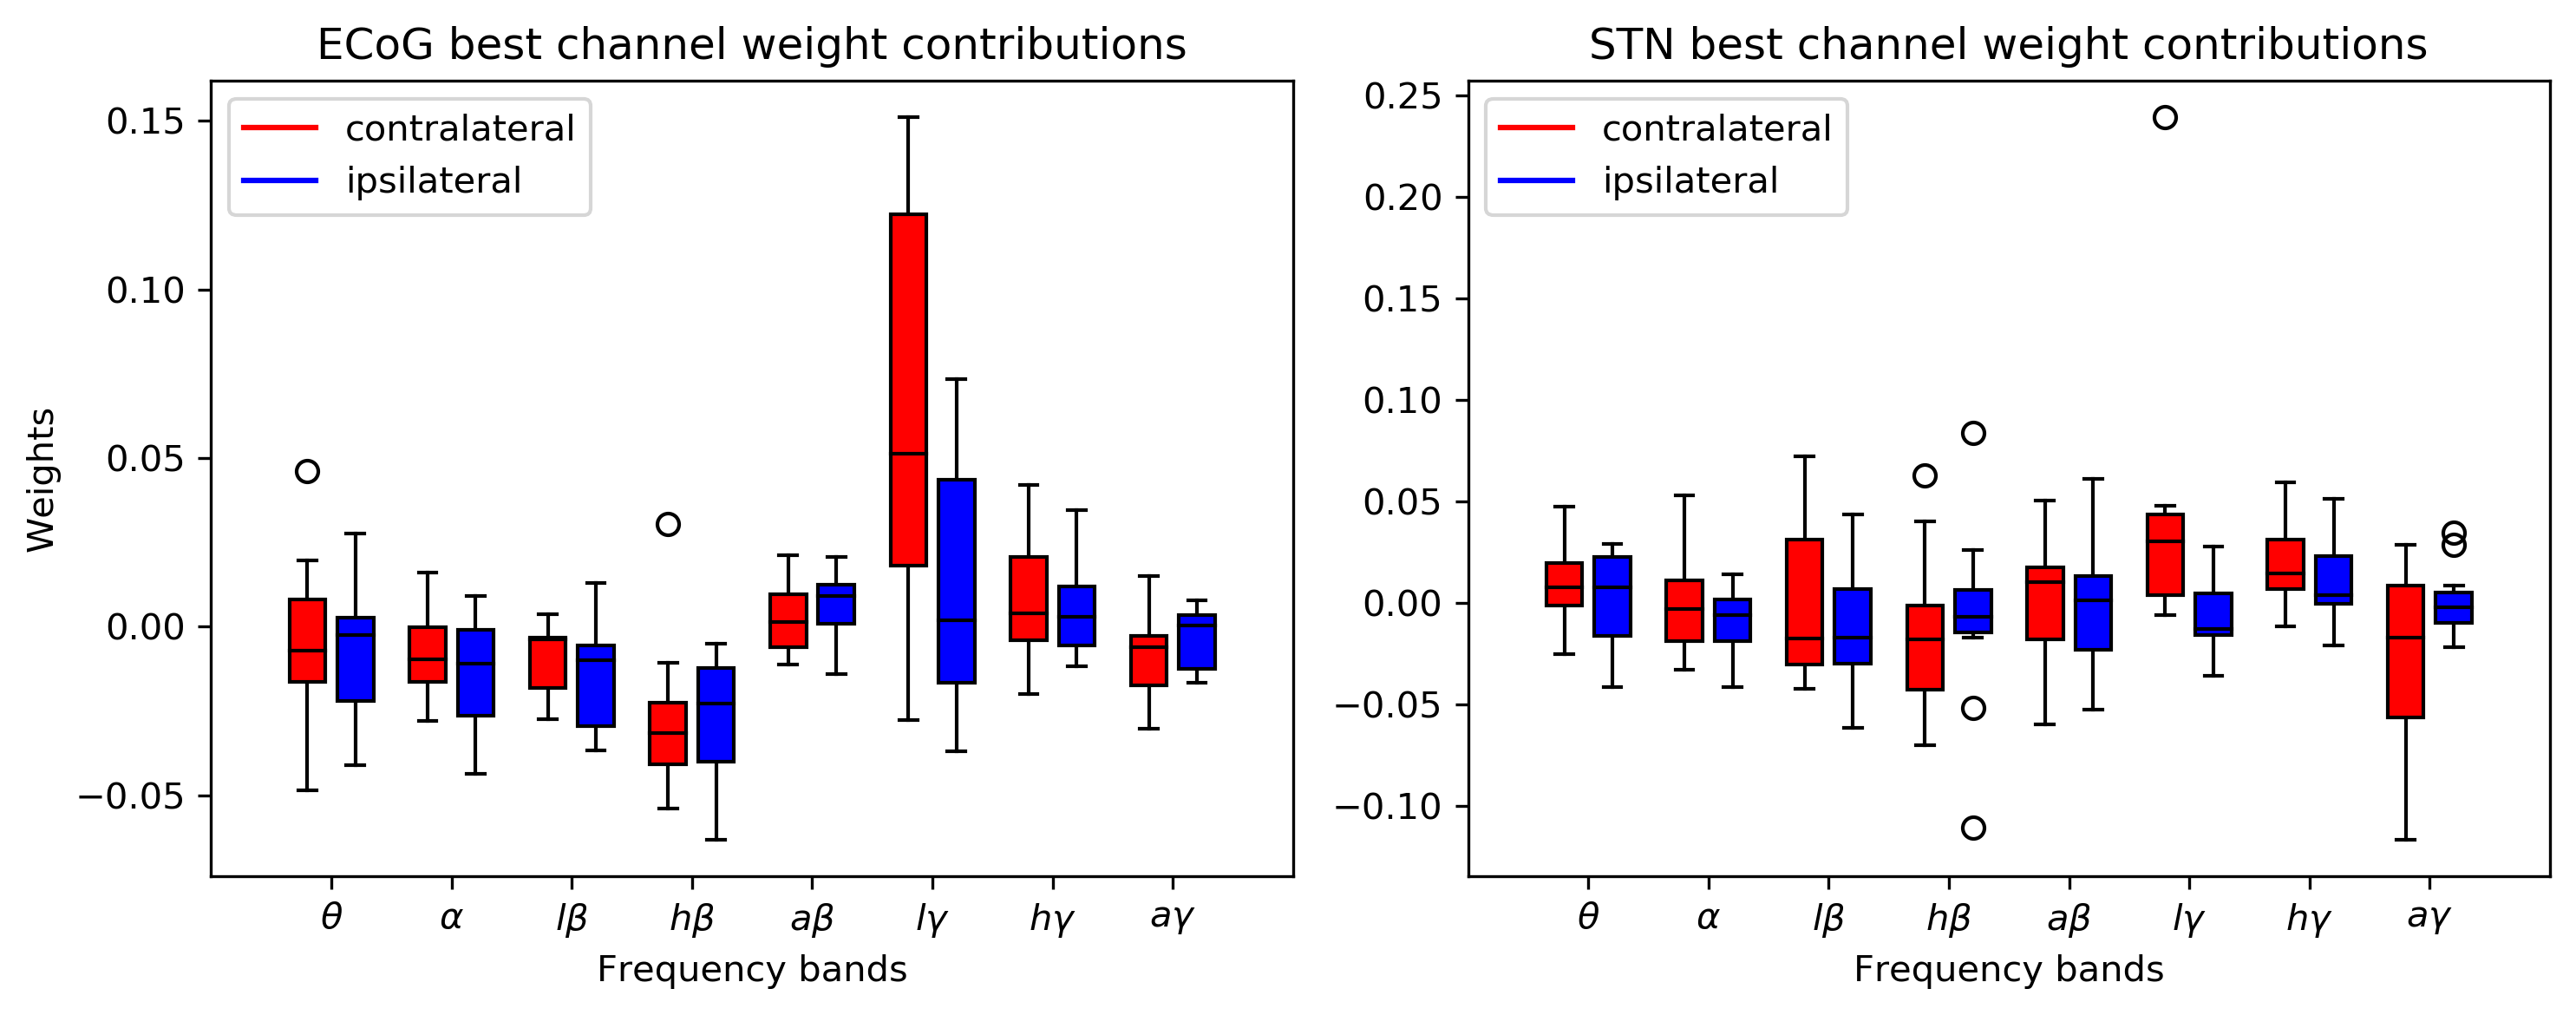

In [14]:
plt.figure(figsize=(10, 4), dpi=300)
plt.subplot(1,2,1)
my_boxplot_weights(get_coeff(loc_="ECOG", mod_="CON"),  get_coeff(loc_="ECOG", mod_="IPS"))
plt.legend()
plt.ylabel('Weights')
#plt.ylim(-2.8,2.2)
plt.title('ECoG best channel weight contributions')
plt.xlabel('Frequency bands'); #plt.grid(True)


plt.subplot(1,2,2)
my_boxplot_weights(get_coeff(loc_="STN", mod_="CON"),  get_coeff(loc_="STN", mod_="IPS"))
plt.legend(loc='upper left')
plt.title('STN best channel weight contributions')
#plt.ylim(-2.8,2.2)
plt.tight_layout()
plt.xlabel('Frequency bands'); #plt.grid(True)
plt.show()

### Repeat plot with individual points

In [16]:
get_coeff(loc_="ECOG", mod_="CON").shape

(11, 8)

In [18]:
# transform data to dataframe 
fbs = [r'$\theta$', r'$\alpha$', r'$l\beta$', r'$h\beta$', \
                         r'$a\beta$', r'$l\gamma$', r'$h\gamma$', r'$a\gamma$']
df = pd.DataFrame()
for loc in ["ECOG", "STN"]:
    for lat in ["CON", "IPS"]:
        data_ = get_coeff(loc_=loc, mod_=lat)
        for patient in range(11):
            for f_band in range(8):
                df = df.append({
                    "Frequency bands":fbs[f_band],
                    "patient":patient,
                    "Weights":data_[patient,f_band],
                    "loc":loc,
                    "lat":lat
                },ignore_index=True)

Text(0.5, 1.0, 'ECOG best channel weight contributions')

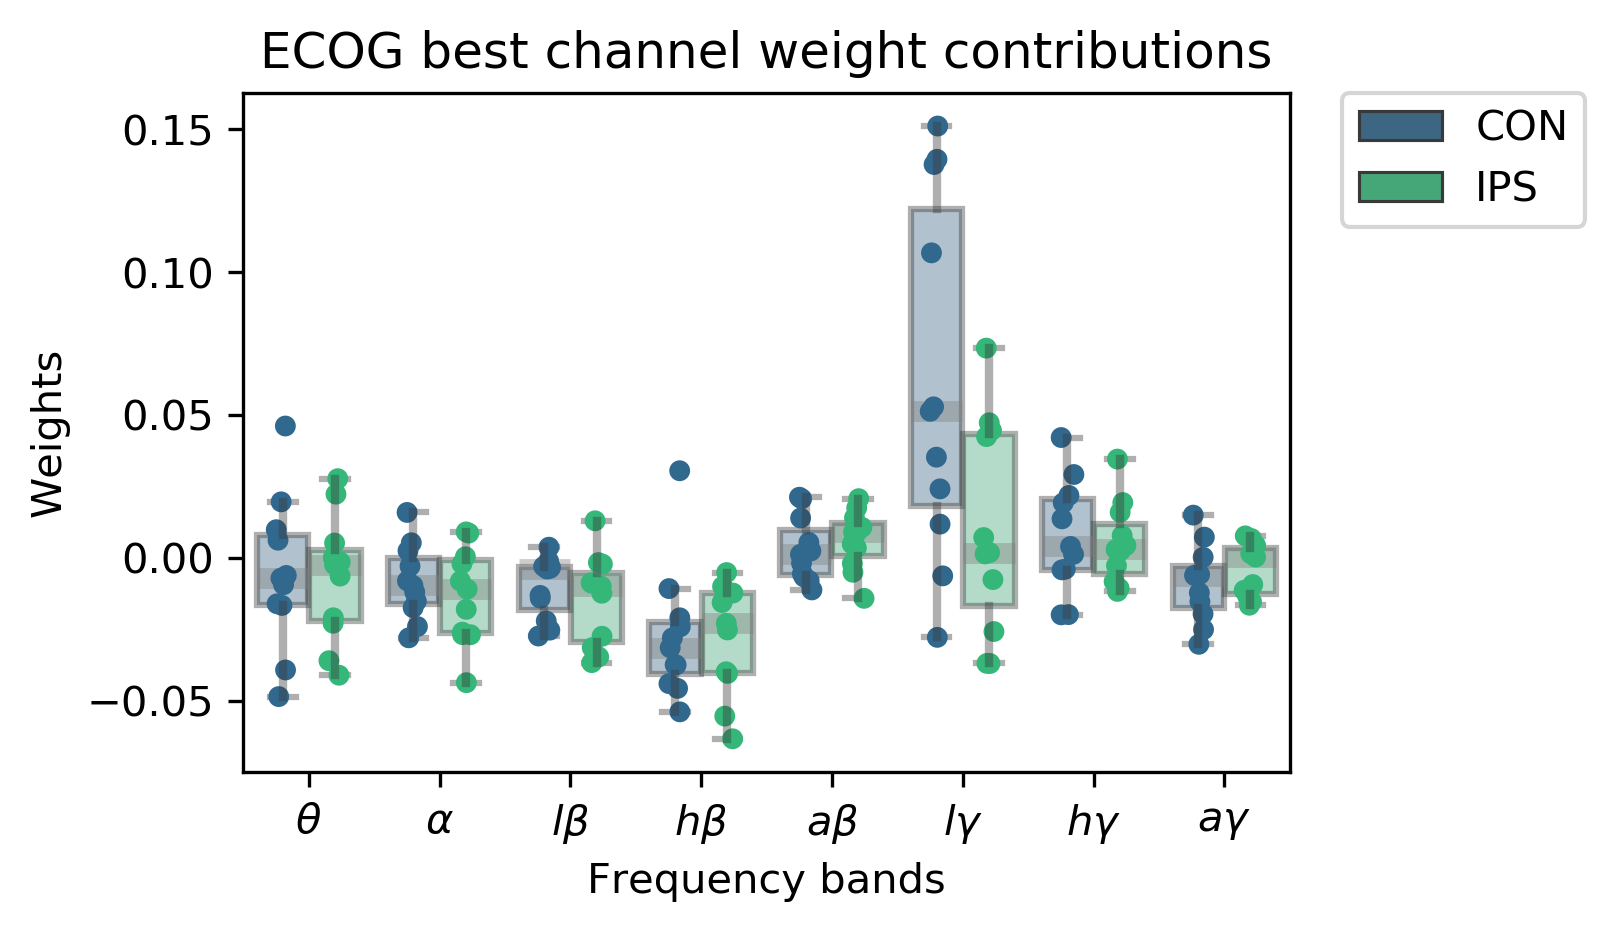

In [32]:
plt.figure(figsize=(4.5,3), dpi=300)
sb.boxplot(x="Frequency bands", y="Weights", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
           data=df[df["loc"] == "ECOG"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))
ax = sb.stripplot(x="Frequency bands", y="Weights", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df[df["loc"] == "ECOG"],palette="viridis", dodge=True, s=5)


# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("ECOG best channel weight contributions")


Text(0.5, 1.0, 'STN best channel weight contributions')

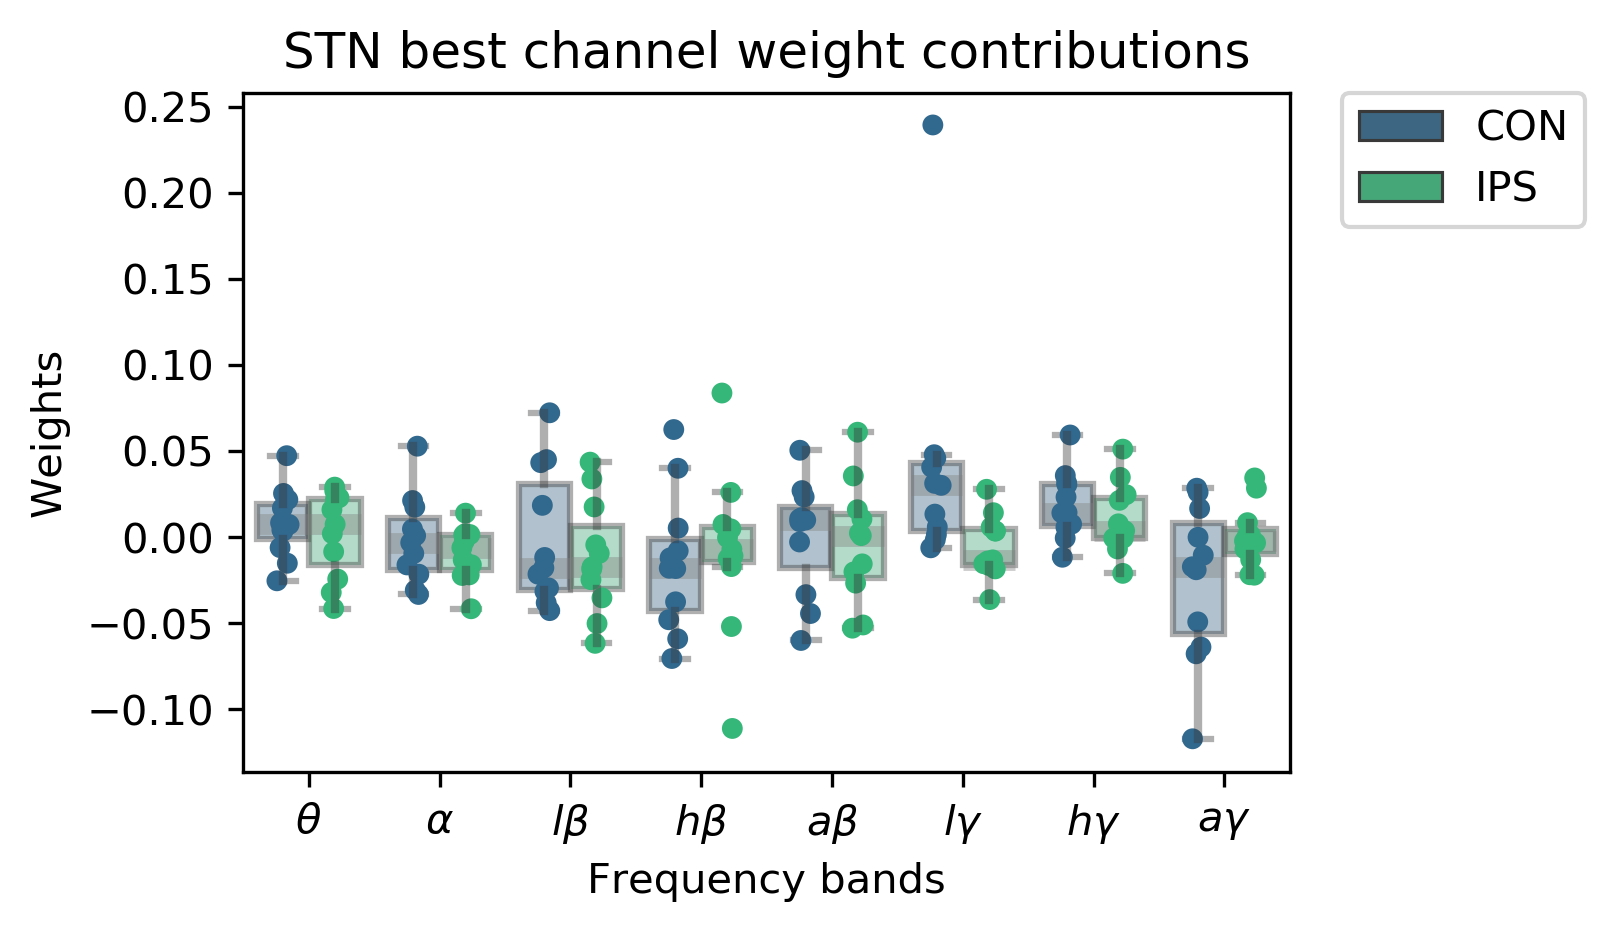

In [33]:
plt.figure(figsize=(4.5,3), dpi=300)
sb.boxplot(x="Frequency bands", y="Weights", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
           data=df[df["loc"] == "STN"], palette="viridis", 
           showmeans=False, boxprops=dict(alpha=alpha_box), showcaps=True, showbox=True, 
           showfliers=False, notch=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="gray", alpha=alpha_box))
ax = sb.stripplot(x="Frequency bands", y="Weights", hue="lat", #order=["LM", "NN", "SPOC_LM", "SPOC_XGB","XGB"], 
             data=df[df["loc"] == "STN"],palette="viridis", dodge=True, s=5)


# When creating the legend, only use the first two elements
# to effectively remove the last two.
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("STN best channel weight contributions")
